In [1]:
# ===============================
# Infant Cry Classification Project
# ===============================

In [2]:
# import packages
# ===============================
import os
import kagglehub
import librosa
import librosa.display
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize
from itertools import product
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
import random
import warnings
warnings.filterwarnings('ignore')

SEED = 42
# Set seed for Python’s built-in random module
random.seed(SEED)
# Set seed for NumPy
np.random.seed(SEED)
# Set seed for TensorFlow
tf.random.set_seed(SEED)
# Ensure deterministic operations in TensorFlow
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensures deterministic behavior
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Ensures deterministic behavior for GPU

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

C:\Users\eli\deep_learning_final_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ===============================
# 1. Load Dataset & Feature Extraction( converting audio into tabular data) (Q1)
# ===============================
def load_audio_dataset():
    """Download dataset from Kaggle and load audio file paths."""
    dataset_path = kagglehub.dataset_download("warcoder/infant-cry-audio-corpus")
    dataset_folder = os.path.join(dataset_path, "donateacry_corpus")

    audio_files = [
        os.path.join(subdir_path, f)
        for subdir in os.listdir(dataset_folder)
        if os.path.isdir(subdir_path := os.path.join(dataset_folder, subdir))
        for f in os.listdir(subdir_path) if f.endswith(('.wav', '.mp3'))
    ]

    print(f"Total audio files found: {len(audio_files)}")
    return audio_files

# Running the Pipeline - Q1
# ===============================
audio_files = load_audio_dataset()

def extract_audio_features(file_path):
    """Extracts MFCC, spectral, and temporal features from an audio file."""
    try:
        y, sr = librosa.load(file_path, sr=None)
        return np.concatenate([
            np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1),
            [np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
             np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
             np.mean(librosa.feature.spectral_flatness(y=y))],
            [np.mean(librosa.feature.rms(y=y)), np.mean(librosa.feature.zero_crossing_rate(y))]
        ])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def prepare_dataframe(audio_files):
    """Extract features using parallel processing and create a DataFrame."""
    features = Parallel(n_jobs=-1)(delayed(extract_audio_features)(file) for file in audio_files)

    # Remove None values (errors during extraction)
    valid_indices = [i for i, f in enumerate(features) if f is not None]
    features = [features[i] for i in valid_indices]
    labels = [audio_files[i].split(os.sep)[-2] for i in valid_indices]  # Folder names as labels

    # Define column names
    columns = [f"mfcc_{i+1}" for i in range(13)] + [
        "spectral_centroid", "spectral_bandwidth", "spectral_flatness", "rms_energy", "zero_crossing_rate"
    ]

    df = pd.DataFrame(features, columns=columns)
    df["label"] = labels
    return df

def enrich_df(df):
    """Enrich dataframe with based audio features """
    df["delta_mfcc_1"] = df["mfcc_1"].diff().fillna(0)
    df["delta_spectral_centroid"] = df["spectral_centroid"].diff().fillna(0)
    df["acceleration_mfcc_1"] = df["delta_mfcc_1"].diff().fillna(0)
    df["acceleration_spectral_centroid"] = df["delta_spectral_centroid"].diff().fillna(0)
    df["mfcc_1_x_spectral_centroid"] = df["mfcc_1"] * df["spectral_centroid"]
    df["mfcc_mean"] = df[[f"mfcc_{i}" for i in range(1, 14)]].mean(axis=1)
    df["mfcc_variance"] = df[[f"mfcc_{i}" for i in range(1, 14)]].var(axis=1)
    df["rms_slope"] = df["rms_energy"].diff().fillna(0)
    df["zero_crossing_slope"] = df["zero_crossing_rate"].diff().fillna(0)
    df["mfcc_low_freq_mean"] = df[[f"mfcc_{i}" for i in range(1, 5)]].mean(axis=1)
    df["mfcc_mid_freq_mean"] = df[[f"mfcc_{i}" for i in range(5, 9)]].mean(axis=1)
    df["mfcc_high_freq_mean"] = df[[f"mfcc_{i}" for i in range(9, 14)]].mean(axis=1)
    df["spectral_centroid_to_bandwidth_ratio"] = df["spectral_centroid"] / (df["spectral_bandwidth"] + 1e-6)

    return df
# Step 1: Extract Features & Create DataFrame
main_dataset = prepare_dataframe(audio_files)
main_dataset = enrich_df(main_dataset)

Total audio files found: 457


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   mfcc_1                                457 non-null    float64
 1   mfcc_2                                457 non-null    float64
 2   mfcc_3                                457 non-null    float64
 3   mfcc_4                                457 non-null    float64
 4   mfcc_5                                457 non-null    float64
 5   mfcc_6                                457 non-null    float64
 6   mfcc_7                                457 non-null    float64
 7   mfcc_8                                457 non-null    float64
 8   mfcc_9                                457 non-null    float64
 9   mfcc_10                               457 non-null    float64
 10  mfcc_11                               457 non-null    float64
 11  mfcc_12            

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,acceleration_spectral_centroid,mfcc_1_x_spectral_centroid,mfcc_mean,mfcc_variance,rms_slope,zero_crossing_slope,mfcc_low_freq_mean,mfcc_mid_freq_mean,mfcc_high_freq_mean,spectral_centroid_to_bandwidth_ratio
0,-405.876007,27.121643,-42.248203,-0.346938,-33.404629,4.665828,-17.678110,2.775190,-8.659680,-9.639956,...,0.000000,-541583.767139,-36.755425,12630.363261,0.000000,0.000000,-105.337376,-10.910430,-2.565861,1.711512
1,-383.836853,38.426846,-19.573414,-8.295807,-19.087879,-19.339636,-16.694019,-14.295871,-14.658418,-14.466269,...,-56.802265,-490372.849874,-38.826712,10975.388480,-0.013500,-0.040940,-93.319807,-17.354351,-12.410125,1.294286
2,-304.175049,41.778366,-26.645769,-17.834066,-29.084251,-16.714413,-19.668499,-15.114859,-17.234325,-9.661561,...,47.054207,-385635.364474,-34.004399,6888.460546,0.007087,0.007994,-76.719130,-20.145505,-10.919730,1.311054
3,-252.537506,35.876537,-35.229088,-20.087469,-29.121031,-21.324640,-22.387121,-8.064095,-21.706665,-13.885673,...,47.451293,-329690.388762,-30.596004,4761.930542,0.008487,0.020317,-67.994381,-20.224222,-8.974728,1.412231
4,-171.509125,41.750740,-15.136597,-21.789589,-37.224899,-26.083990,-20.842268,-14.546901,-14.981940,-10.887066,...,-99.751506,-213265.134035,-24.021963,2298.373014,0.022473,-0.028085,-41.671143,-24.674515,-9.380577,1.240880


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,acceleration_spectral_centroid,mfcc_1_x_spectral_centroid,mfcc_mean,mfcc_variance,rms_slope,zero_crossing_slope,mfcc_low_freq_mean,mfcc_mid_freq_mean,mfcc_high_freq_mean,spectral_centroid_to_bandwidth_ratio
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,...,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,-245.335367,29.989186,-27.905965,-7.224950,-22.397562,-2.695800,-14.706442,-6.678211,-13.251914,-4.191660,...,-1.583622,-325263.466672,-25.246712,5759.573735,-0.000041,-0.000258,-62.619274,-11.619504,-6.250428,1.558488
std,114.045705,32.103852,20.351424,13.758638,12.518707,11.831383,8.642670,7.536932,6.811712,7.098796,...,533.078172,149887.528618,8.079697,5055.716542,0.080354,0.091759,26.329796,5.380400,3.921542,0.304996
min,-660.576172,-67.316086,-88.593086,-58.162952,-59.831417,-41.966011,-46.204361,-26.269297,-36.057880,-20.835262,...,-1823.527052,-844842.429862,-49.940538,65.221481,-0.349586,-0.332575,-148.609819,-31.747211,-16.796209,0.909305
25%,-313.753693,11.837775,-40.569492,-15.763538,-30.113272,-9.965248,-19.937622,-12.406818,-17.253868,-9.441170,...,-348.977594,-405734.550606,-30.214509,2302.399463,-0.037572,-0.050386,-78.232468,-15.239784,-9.129904,1.328397
50%,-232.681992,32.992836,-26.973442,-7.333104,-22.231724,-2.463378,-14.599815,-6.616596,-13.485116,-4.790479,...,14.321907,-303584.862358,-25.144626,4247.171910,0.001572,0.000963,-60.641218,-11.306193,-6.131306,1.529543
75%,-164.496628,50.021328,-14.010734,1.808073,-13.807454,5.017297,-9.422608,-1.647675,-8.809354,0.396191,...,349.989538,-218012.286753,-19.325206,7454.103834,0.036739,0.056281,-43.889272,-8.172834,-3.407449,1.748546
max,-14.803537,140.837952,26.478243,43.641239,9.735763,31.820400,9.009636,16.501274,14.291714,23.240492,...,1629.817587,-28795.199139,-1.742627,34661.396283,0.274148,0.308544,14.273466,1.467916,3.326331,2.869627


None

mfcc_1                                  0
mfcc_2                                  0
mfcc_3                                  0
mfcc_4                                  0
mfcc_5                                  0
mfcc_6                                  0
mfcc_7                                  0
mfcc_8                                  0
mfcc_9                                  0
mfcc_10                                 0
mfcc_11                                 0
mfcc_12                                 0
mfcc_13                                 0
spectral_centroid                       0
spectral_bandwidth                      0
spectral_flatness                       0
rms_energy                              0
zero_crossing_rate                      0
label                                   0
delta_mfcc_1                            0
delta_spectral_centroid                 0
acceleration_mfcc_1                     0
acceleration_spectral_centroid          0
mfcc_1_x_spectral_centroid        

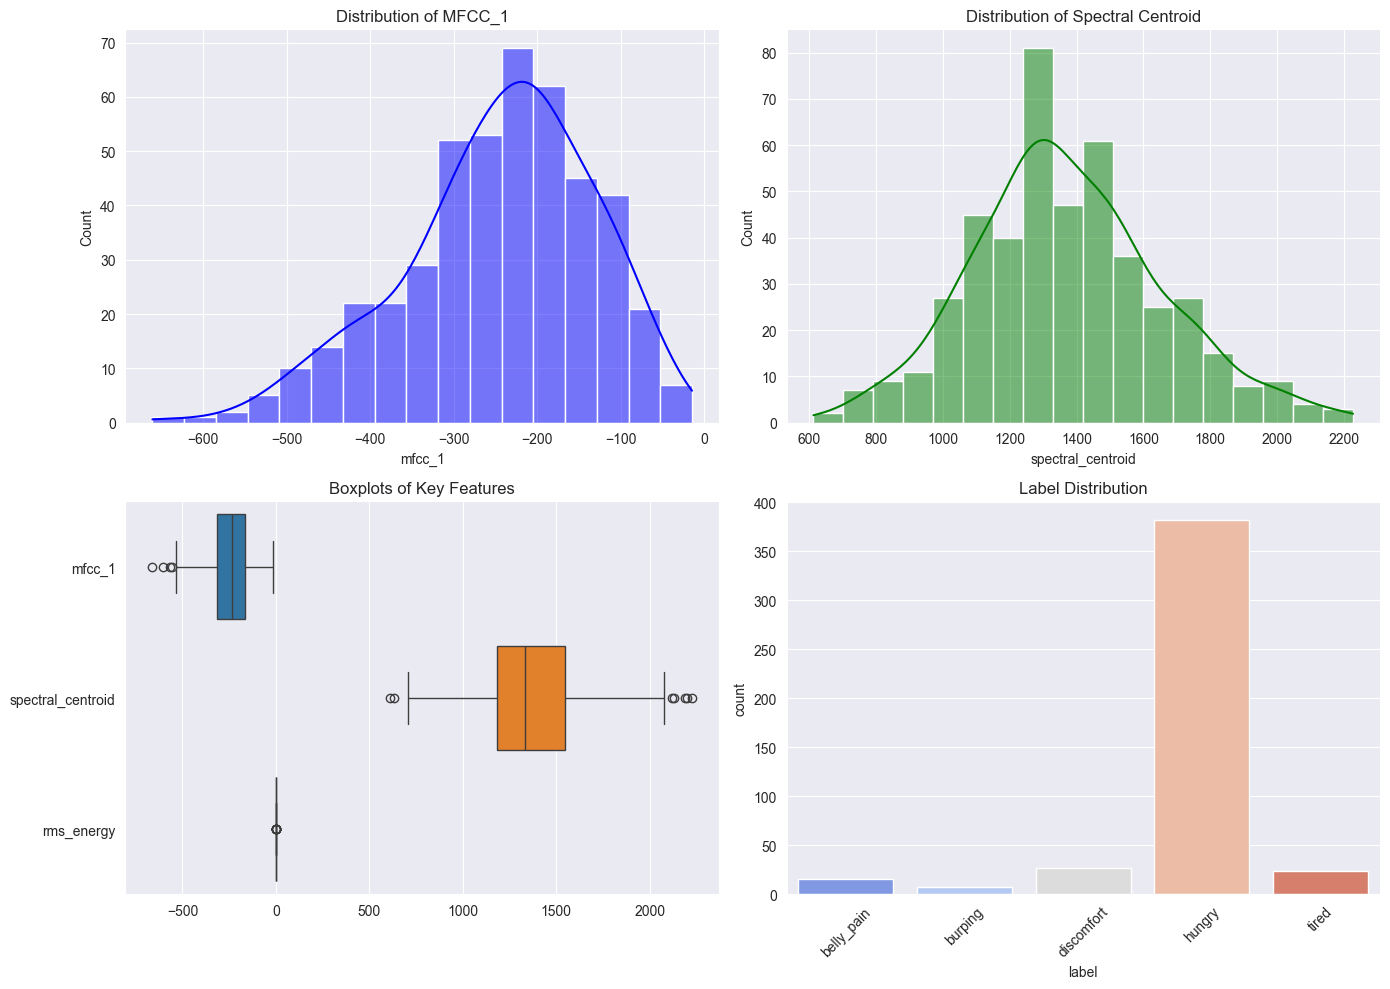

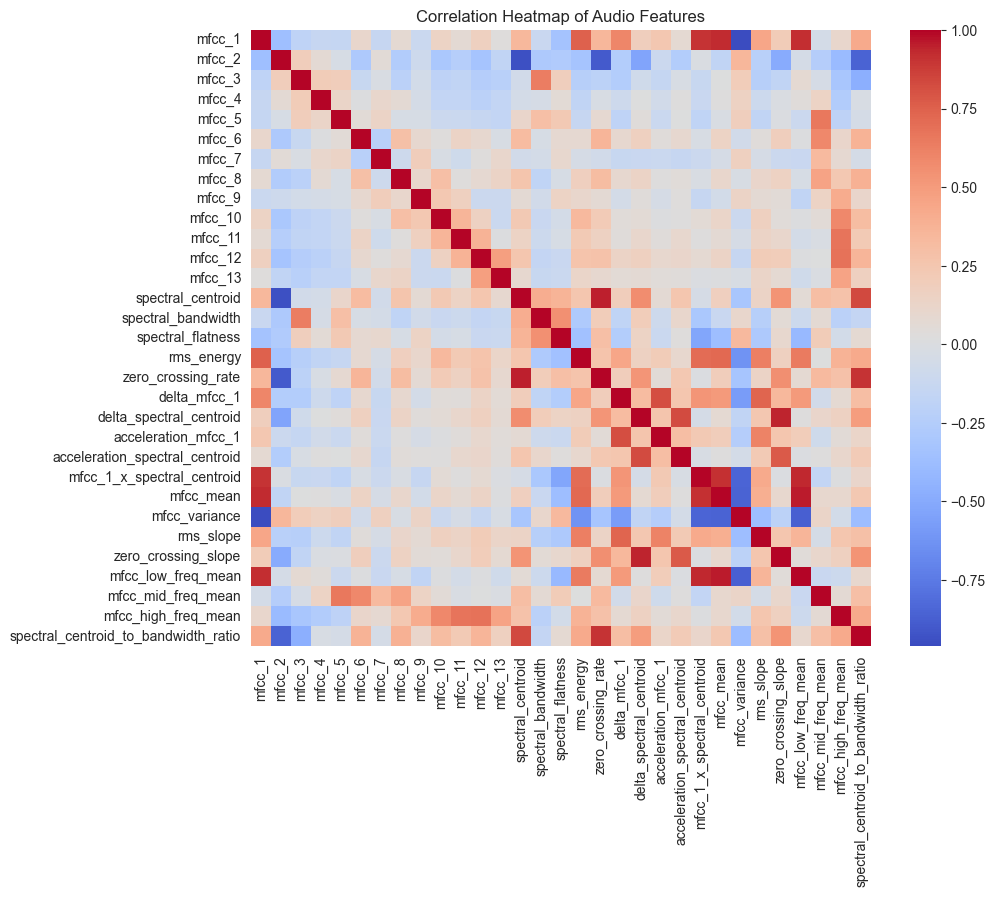

In [4]:
# ===============================
# 2. EDA (Q2)
# ===============================
def eda(main_dataset):
    """Perform Exploratory Data Analysis (EDA) on the dataset."""

    # Basic Overview
    display(main_dataset.head(), main_dataset.describe(), main_dataset.info(), main_dataset.isnull().sum())

    # Create Subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Feature Distributions
    sns.histplot(main_dataset['mfcc_1'], kde=True, color='blue', ax=axes[0, 0])
    axes[0, 0].set_title("Distribution of MFCC_1")

    sns.histplot(main_dataset['spectral_centroid'], kde=True, color='green', ax=axes[0, 1])
    axes[0, 1].set_title("Distribution of Spectral Centroid")

    # Boxplot for Outliers
    sns.boxplot(data=main_dataset[['mfcc_1', 'spectral_centroid', 'rms_energy']], orient='h', ax=axes[1, 0])
    axes[1, 0].set_title("Boxplots of Key Features")

    # Label Distribution (as a Bar Chart)
    sns.countplot(x=main_dataset['label'], ax=axes[1, 1], palette="coolwarm")
    axes[1, 1].set_title("Label Distribution")
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(main_dataset.corr(numeric_only=True), annot=False, cmap='coolwarm')
    plt.title("Correlation Heatmap of Audio Features")
    plt.show()

# Run the function
eda(main_dataset)

In [5]:
# ===============================
# 3. data preprocessing (Q3) - part 1 ( sections a, b)
# ===============================
def preprocess_data_before_split(main_dataset):
    """Preprocess dataset: cleaning, encoding, and handling outliers before splitting."""

    # 3a: data cleaning
    # Remove duplicates
    print(f"Duplicate rows removed: {main_dataset.duplicated().sum()}")
    main_dataset = main_dataset.drop_duplicates()

    # Encode categorical labels
    encoder = LabelEncoder()
    main_dataset["label"] = encoder.fit_transform(main_dataset["label"])


    # 3b:Handle missing values
    print(f"Missing values before handling: {main_dataset.isnull().sum().sum()}")
    main_dataset = main_dataset.fillna(main_dataset.median())  # Fill with median

    # Handle outliers separately
    main_dataset = handle_outliers(main_dataset)

    return main_dataset

def handle_outliers(df):
    """Apply log transformation and winsorization to handle outliers."""
    df["spectral_centroid"] = np.log1p(df["spectral_centroid"])  # Log transformation for skewed data
    df["mfcc_1"] = winsorize(df["mfcc_1"],
                                         limits=[0.05, 0.05])  # Winsorization (remove extreme outliers)

    return df

# ===============================
# 4. split data (Q4)
# ===============================
def split_data(X, y):
    """Split dataset into train (80%), validation (10%), and test (10%)."""

    # Step 1: Split Train (80%) and Temp (20%) using stratification
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Step 2: Split Temp into Validation (10%) and Test (10%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# ===============================
# 3. Preprocessing on Train - Step 2 (Dimensionality Reduction, Balancing, Scaling)
# ===============================
# 3c: reduce_dimensions
def reduce_dimensions(X_train, X_val, X_test):
    """Apply PCA for dimensionality reduction."""

    # Standardize before PCA
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA (keep 95% variance)
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, X_val_pca, X_test_pca

## 3d: balancing the dataset
def apply_smote(X_train, y_train):
    """Apply SMOTE for balancing (Q3.d)."""
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    return smote.fit_resample(X_train, y_train)

# 3e: normalization
def normalize_data(X_train, X_val, X_test):
    """Apply standard normalization (Q3.e)."""
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_val), scaler.transform(X_test)

# 3f: Feature Engineering
def apply_exponentiation_to_pca(X_scaled, exponent=2):
    """Apply exponentiation transformation to PCA components."""
    X_scaled_df = pd.DataFrame(X_scaled).pow(exponent)  # Vectorized operation
    return X_scaled_df

## ✅ Run the pipeline
def q3_q4_pipeline(main_dataset):
    """Pipeline for Preprocessing & Data Splitting (Q3 & Q4)."""

    print("\n✅ Step 1: Preprocessing Before Splitting...")
    main_dataset = preprocess_data_before_split(main_dataset)

    # ✅ Separate Features & Labels
    X = main_dataset.drop(columns=["label"])
    y = main_dataset["label"]

    print("\n✅ Step 2: Splitting Data...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    print("\n✅ Step 3: Applying PCA for Dimensionality Reduction...")
    X_train_pca, X_val_pca, X_test_pca = reduce_dimensions(X_train, X_val, X_test)

    print("\n✅ Step 4: Applying SMOTE for Balancing...")
    X_train_balanced, y_train_balanced = apply_smote(X_train_pca, y_train)

    print("\n✅ Step 5: Normalizing Features...")
    X_train_scaled, X_val_scaled, X_test_scaled = normalize_data(X_train_balanced, X_val_pca,
                                                                 X_test_pca)  # ✅ Fix function name

    print("\n✅ Step 6: Feature Engineering (Exponentiation)...")
    X_train_final = apply_exponentiation_to_pca(X_train_scaled).values  # ✅ Convert to NumPy
    X_val_final = apply_exponentiation_to_pca(X_val_scaled).values
    X_test_final = apply_exponentiation_to_pca(X_test_scaled).values

    print("\n✅ Preprocessing & Data Splitting Completed!")
    return X_train_final, X_val_final, X_test_final, y_train_balanced, y_val, y_test


# 🚀 Run the Fixed Pipeline
X_train_final, X_val_final, X_test_final, y_train_balanced, y_val, y_test = q3_q4_pipeline(main_dataset)


✅ Step 1: Preprocessing Before Splitting...
Duplicate rows removed: 0
Missing values before handling: 0

✅ Step 2: Splitting Data...
Train: (365, 31), Validation: (46, 31), Test: (46, 31)

✅ Step 3: Applying PCA for Dimensionality Reduction...

✅ Step 4: Applying SMOTE for Balancing...

✅ Step 5: Normalizing Features...

✅ Step 6: Feature Engineering (Exponentiation)...

✅ Preprocessing & Data Splitting Completed!


  File "C:\Users\eli\deep_learning_final_project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\eli\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\eli\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\eli\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1491, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [6]:
# insights/ summaty
# dataset has 0 duplications and msising values
# we found 2 features with outliers, handled them with log.
# we splited the data to train, val and test with stratify y.
# we encoded our target variable
# we applied PCA to reduce dimension, smote to balance the dataset


🚀 Training Decision Tree...


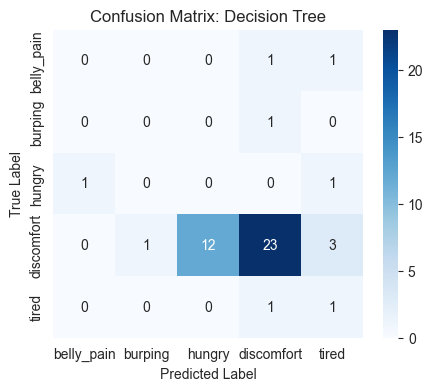


Classification Report (Decision Tree):
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         2
     burping       0.00      0.00      0.00         1
      hungry       0.00      0.00      0.00         2
  discomfort       0.88      0.59      0.71        39
       tired       0.17      0.50      0.25         2

    accuracy                           0.52        46
   macro avg       0.21      0.22      0.19        46
weighted avg       0.76      0.52      0.61        46


🚀 Training SVM...


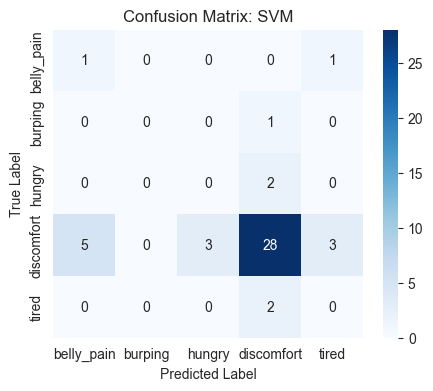


Classification Report (SVM):
              precision    recall  f1-score   support

  belly_pain       0.17      0.50      0.25         2
     burping       0.00      0.00      0.00         1
      hungry       0.00      0.00      0.00         2
  discomfort       0.85      0.72      0.78        39
       tired       0.00      0.00      0.00         2

    accuracy                           0.63        46
   macro avg       0.20      0.24      0.21        46
weighted avg       0.73      0.63      0.67        46


🚀 Training Logistic Regression...


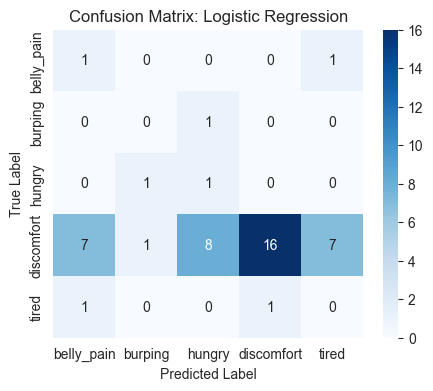


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  belly_pain       0.11      0.50      0.18         2
     burping       0.00      0.00      0.00         1
      hungry       0.10      0.50      0.17         2
  discomfort       0.94      0.41      0.57        39
       tired       0.00      0.00      0.00         2

    accuracy                           0.39        46
   macro avg       0.23      0.28      0.18        46
weighted avg       0.81      0.39      0.50        46


Final Model Comparison (Sorted by F1-Score):
                 Model  Train Accuracy  Test Accuracy  Precision    Recall  \
0                  SVM        0.905574       0.630435   0.203030  0.243590   
1        Decision Tree        1.000000       0.521739   0.210256  0.217949   
2  Logistic Regression        0.635410       0.391304   0.230458  0.282051   

   F1-Score  
0  0.205556  
1  0.191538  
2  0.183983  

🏆 Best Model by F1-Score: SVM
   🔹 Train Accuracy

In [7]:
# ================================
# Q5 - Train baseline model and  Q6- Review results according to 3-5 evolution metrics
# ================================
def inspect_class_level_performance(y_true, y_pred, class_names, model_name="Model"):
    """
    Plots a confusion matrix and prints a detailed classification report.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y_true, y_pred, target_names=class_names))

y_train_encoded = y_train_balanced
y_test_encoded  = y_test


def baseline_pipeline(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    # ✅ Ensure reproducibility
    RANDOM_STATE = 42
    models = {
        "Decision Tree": DecisionTreeClassifier(
            random_state=RANDOM_STATE,
            class_weight="balanced"  # or a custom dict
        ),
        "SVM": SVC(
            probability=True,
            random_state=RANDOM_STATE,
            class_weight="balanced"
        ),
        "Logistic Regression": LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight="balanced"
        )
    }
    results_list = []
    for model_name, model in models.items():
        print(f"\n🚀 Training {model_name}...")

        # 1) Fit on train
        model.fit(X_train_scaled, y_train_encoded)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred  = model.predict(X_test_scaled)

        my_class_names = ['belly_pain', 'burping', 'hungry', 'discomfort', 'tired']

        # 2) Inspect performance
        inspect_class_level_performance(
            y_true=y_test_encoded,
            y_pred=y_test_pred,
            class_names=my_class_names,
            model_name=model_name
        )

        # 3) Compute standard metrics (macro average)
        train_acc = accuracy_score(y_train_encoded, y_train_pred)
        test_acc  = accuracy_score(y_test_encoded, y_test_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded, y_test_pred, pos_label=1, average="macro")


        # 4) Store results
        results_list.append({
            "Model": model_name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })

    # Convert to DataFrame
    model_results_df = pd.DataFrame(results_list)

    # Sort by your chosen criterion, e.g. F2
    model_results_df = model_results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

    print("\nFinal Model Comparison (Sorted by F1-Score):")
    print(model_results_df)

    best_model_row = model_results_df.iloc[0]
    print(f"\n🏆 Best Model by F1-Score: {best_model_row['Model']}")
    print(f"   🔹 Train Accuracy: {best_model_row['Train Accuracy']:.4f}")
    print(f"   🔹 Test Accuracy: {best_model_row['Test Accuracy']:.4f}")
    print(f"   🔹 Precision: {best_model_row['Precision']:.4f}")
    print(f"   🔹 Recall: {best_model_row['Recall']:.4f}")
    print(f"   🔹 F1-Score: {best_model_row['F1-Score']:.4f}")

    return best_model_row, model_results_df

best_model_row, model_results_df = baseline_pipeline(X_train_final, X_test_final, y_train_balanced, y_test)

In [9]:
# ================================
# Train Default MLP Model (Q7)
# ================================
def train_mlp(X_train, X_val, X_test, y_train, y_val, y_test):
    """Trains an MLP Neural Network and selects the best model based on lowest validation loss."""

    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    model = Sequential([
        Dense(100, activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(50, activation="relu"),
        Dropout(0.1),
        Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer=Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # ✅ EarlyStopping based on Validation Loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train_cat,
                        validation_data=(X_val, y_val_cat),
                        epochs=50, batch_size=32, verbose=1,
                        callbacks=[early_stopping])

    # ✅ Get the best Train Accuracy from history
    best_train_acc = max(history.history['accuracy'])
    best_val_acc = max(history.history['val_accuracy'])

    # ✅ Evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, to_categorical(y_test, num_classes), verbose=1)

    # ✅ Predict for evaluation
    y_test_pred_proba = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred_proba, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="macro")

    print(f"\n✅ Default MLP Model Evaluation:")
    print(f"Train Accuracy: {best_train_acc:.4f}")
    print(f"Validation Accuracy: {best_val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


    # ✅ Store results in a DataFrame
    mlp_results_df = pd.DataFrame([{
        "Model": "MLP Neural Network",
        "Train Accuracy": best_train_acc,
        "Validation Accuracy": best_val_acc,
        "Test Accuracy": test_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }])

    return model, mlp_results_df

model, mlp_results_df = train_mlp(X_train_final, X_val_final, X_test_final, y_train_balanced, y_val, y_test)


Epoch 1/50


48/48 [==============================] - 1s 4ms/step - loss: 1.5329 - accuracy: 0.3108 - val_loss: 1.2783 - val_accuracy: 0.5652
Epoch 2/50
48/48 [==============================] - 0s 1ms/step - loss: 1.2544 - accuracy: 0.5016 - val_loss: 1.4135 - val_accuracy: 0.5217
Epoch 3/50
48/48 [==============================] - 0s 1ms/step - loss: 1.0498 - accuracy: 0.6374 - val_loss: 1.3235 - val_accuracy: 0.6522
Epoch 4/50
48/48 [==============================] - 0s 1ms/step - loss: 0.9691 - accuracy: 0.6590 - val_loss: 1.5513 - val_accuracy: 0.4565
Epoch 5/50
48/48 [==============================] - 0s 1ms/step - loss: 0.8526 - accuracy: 0.7200 - val_loss: 1.5073 - val_accuracy: 0.5652
Epoch 6/50
2/2 [==============================] - 0s 10ms/step

✅ Default MLP Model Evaluation:
Train Accuracy: 0.7397
Validation Accuracy: 0.6522
Test Accuracy: 0.6087
Precision: 0.2742
Recall: 0.3385
F1-Score: 0.2876


In [10]:
model_results_df = pd.concat([model_results_df, mlp_results_df], ignore_index=True)
model_results_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Validation Accuracy
0,SVM,0.905574,0.630435,0.203030,0.243590,0.205556,NaN
1,Decision Tree,1.000000,0.521739,0.210256,0.217949,0.191538,NaN
2,Logistic Regression,0.635410,0.391304,0.230458,0.282051,0.183983,NaN
3,MLP Neural Network,0.739672,0.608696,0.274194,0.338462,0.287619,0.652174


In [12]:
# ===============================
# Optimized Hyperparameter Tuning for MLP (Q9)
# ===============================
def train_and_evaluate_mlp(alpha, dropout, optimizer, X_train_scaled, X_val_scaled, X_test_scaled,
                           y_train_balanced, y_val, y_test, num_classes):
    """Train an MLP model with given hyperparameters and evaluate performance."""
    # ✅ Set random seed inside the function (important for parallel processing)
    SEED = 42
    import os
    import random
    import numpy as np
    import tensorflow as tf

    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    model = Sequential([
        Dense(100, activation="relu", kernel_regularizer=l2(alpha), input_shape=(X_train_scaled.shape[1],)),
        Dropout(dropout),
        Dense(50, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer=Adam() if optimizer == "adam" else SGD() if optimizer == "sgd" else RMSprop(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train model
    history = model.fit(
        X_train_scaled, to_categorical(y_train_balanced, num_classes),
        validation_data=(X_val_scaled, to_categorical(y_val, num_classes)),
        epochs=50, batch_size=32, verbose=0,
        callbacks=[early_stopping]
    )

    # Stop early if validation accuracy is too low
    if max(history.history['val_accuracy']) < 0.50:
        return None
    # ✅ Get the best training accuracy
    best_train_acc = max(history.history['accuracy'])
    # Get best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])

    # Evaluate on test set
    y_test_pred_proba = model.predict(X_test_scaled)
    y_test_pred_mlp = np.argmax(y_test_pred_proba, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_mlp, average="macro")
    auc_mlp = roc_auc_score(to_categorical(y_test, num_classes), y_test_pred_proba, multi_class="ovr")

    return {
        "Alpha (L2)": alpha,
        "Dropout Rate": dropout,
        "Optimizer": optimizer,
        "Train Accuracy": best_train_acc,
        "Validation Accuracy": best_val_acc,
        "Test Accuracy": accuracy_score(y_test, y_test_pred_mlp),
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": auc_mlp
    }


def tune_mlp_hyperparameters(X_train_scaled, X_val_scaled, X_test_scaled, y_train_balanced, y_val, y_test):
    """Optimize MLP hyperparameters using parallelized grid search."""

    num_classes = len(np.unique(y_train_balanced))

    alpha_options = [0.0001, 0.001, 0.01, 0.1]  # ✅ Expanded range for better regularization
    dropout_options = [0.05, 0.1, 0.2, 0.3]  # ✅ More variation in dropout
    optimizer_options = ["adam", "sgd", "rmsprop"]

    # Perform parallelized grid search
    results = Parallel(n_jobs=-1)(delayed(train_and_evaluate_mlp)(
        alpha, dropout, optimizer, X_train_scaled, X_val_scaled, X_test_scaled,
        y_train_balanced, y_val, y_test, num_classes
    ) for alpha, dropout, optimizer in product(alpha_options, dropout_options, optimizer_options))

    # Remove None values (low accuracy models)
    results = [r for r in results if r is not None]

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Select best model based on **F1-Score**, then Validation Accuracy
    best_model = results_df.sort_values(by=["F1-Score", "Validation Accuracy"], ascending=False).iloc[0]

    print("\n✅ Best Tuned MLP Model:\n", best_model)

    return best_model.to_dict(), results_df


# 🚀 Run Hyperparameter Tuning (Q9)
best_model_results, tuned_results_df = tune_mlp_hyperparameters(
   X_train_final, X_val_final, X_test_final, y_train_balanced, y_val, y_test
)


✅ Best Tuned MLP Model:
 Alpha (L2)               0.0001
Dropout Rate                0.2
Optimizer               rmsprop
Train Accuracy         0.769836
Validation Accuracy    0.695652
Test Accuracy          0.565217
Precision              0.372414
Recall                 0.328205
F1-Score               0.347059
ROC-AUC                0.722579
Name: 8, dtype: object


In [13]:
# Convert best model results dictionary into a DataFrame (single-row)
best_model_results = pd.DataFrame([best_model_results])  # Wrap in a list

# Concatenate with the previous model results DataFrame
model_results_df = pd.concat([model_results_df, best_model_results], ignore_index=True)
# Replace NaN in 'Model' column with 'Tuned MLP'
model_results_df["Model"].fillna("Tuned MLP", inplace=True)

# Display the updated results
print(model_results_df)

                 Model  Train Accuracy  Test Accuracy  Precision    Recall  \
0                  SVM        0.905574       0.630435   0.203030  0.243590   
1        Decision Tree        1.000000       0.521739   0.210256  0.217949   
2  Logistic Regression        0.635410       0.391304   0.230458  0.282051   
3   MLP Neural Network        0.739672       0.608696   0.274194  0.338462   
4            Tuned MLP        0.769836       0.565217   0.372414  0.328205   

   F1-Score  Validation Accuracy  Alpha (L2)  Dropout Rate Optimizer   ROC-AUC  
0  0.205556                  NaN         NaN           NaN       NaN       NaN  
1  0.191538                  NaN         NaN           NaN       NaN       NaN  
2  0.183983                  NaN         NaN           NaN       NaN       NaN  
3  0.287619             0.652174         NaN           NaN       NaN       NaN  
4  0.347059             0.695652      0.0001           0.2   rmsprop  0.722579  


In [ ]:
# Key Insights so far form baseline, mlp and tuned mlp models
# SVM performed best in terms of test accuracy (63.04%) but had a lower recall than MLP models.
# Decision Tree severely overfitted (100% train accuracy vs. 52.17% test accuracy).
# Logistic Regression failed to capture non-linear relationships, making it the weakest model.
# Default MLP achieved better recall than baseline models, meaning it detected more true positive cases.
# Tuned MLP outperformed all models in F1-score (34.71%), showing the best balance between precision and recall.
# The ROC-AUC score (72.26%) of the Tuned MLP suggests that the model can effectively distinguish between different classes.
# Applying L2 regularization (0.0001) and dropout (20%) improved the generalization of the MLP.
# 🚀 Final Recommendation:
# If high accuracy is the goal, SVM is preferred (best test accuracy: 63.04%).
# If balanced precision-recall is needed, Tuned MLP is the best choice (best F1-score: 34.71%).
# Future improvements could include further hyperparameter tuning, experimenting with different optimizers (e.g., Adam), and applying more robust class-balancing techniques.

Total audio files found: 457
Duplicate rows removed: 0
Missing values before handling: 0
Train: (1528, 16), Validation: (191, 16), Test: (191, 16)

🚀 Training Decision Tree...


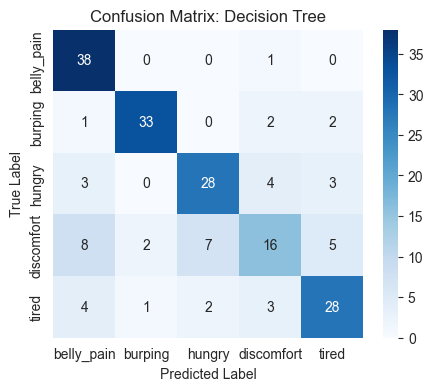


Classification Report (Decision Tree):
              precision    recall  f1-score   support

  belly_pain       0.70      0.97      0.82        39
     burping       0.92      0.87      0.89        38
      hungry       0.76      0.74      0.75        38
  discomfort       0.62      0.42      0.50        38
       tired       0.74      0.74      0.74        38

    accuracy                           0.75       191
   macro avg       0.75      0.75      0.74       191
weighted avg       0.75      0.75      0.74       191


🚀 Training SVM...


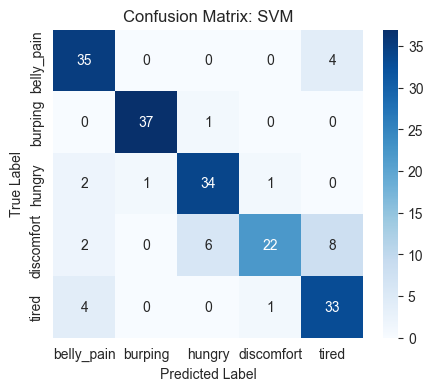


Classification Report (SVM):
              precision    recall  f1-score   support

  belly_pain       0.81      0.90      0.85        39
     burping       0.97      0.97      0.97        38
      hungry       0.83      0.89      0.86        38
  discomfort       0.92      0.58      0.71        38
       tired       0.73      0.87      0.80        38

    accuracy                           0.84       191
   macro avg       0.85      0.84      0.84       191
weighted avg       0.85      0.84      0.84       191


🚀 Training Logistic Regression...


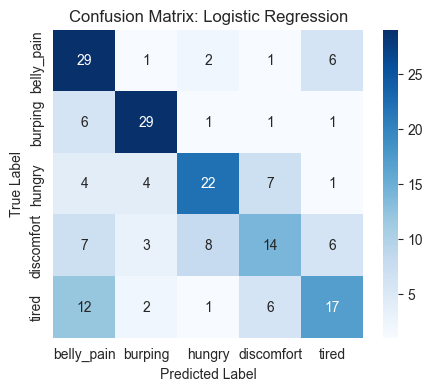


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  belly_pain       0.50      0.74      0.60        39
     burping       0.74      0.76      0.75        38
      hungry       0.65      0.58      0.61        38
  discomfort       0.48      0.37      0.42        38
       tired       0.55      0.45      0.49        38

    accuracy                           0.58       191
   macro avg       0.58      0.58      0.57       191
weighted avg       0.58      0.58      0.57       191


Final Model Comparison (Sorted by F1-Score):
                 Model  Train Accuracy  Test Accuracy  Precision    Recall  \
0                  SVM        0.892016       0.842932   0.853381  0.842645   
1        Decision Tree        1.000000       0.748691   0.745871  0.747503   
2  Logistic Regression        0.621728       0.581152   0.584359  0.580297   

   F1-Score  
0  0.838592  
1  0.738521  
2  0.574592  

🏆 Best Model by F1-Score: SVM
   🔹 Train Accuracy

In [15]:
# Changing the dataset for improved results (Q10)
# ===============================
# in the pipeline so far we changed the order of our answering, we found out that performing questions 3 - c,d,e before splitting to train and test leads to extremly postive but not reliable results.
# this way we change the dataset in terms of applying smote, pca and normalization on a different way from before.
# we use this question to showcase the huge changes in results.

# first of all we will save the current results we have
old_results_df = model_results_df.copy()


def question_ten_pipeline():
    # Running the Pipelines - Q1
    audio_files = load_audio_dataset()
    df = prepare_dataframe(audio_files)
    main_dataset = enrich_df(df)
    # ================================
    # run part 1 ( sections a, b)
    main_dataset = preprocess_data_before_split(main_dataset)

    ## 3c: reducing dimensions
    # Standardize the data before PCA
    X = main_dataset.drop(columns=["label"])
    y = main_dataset["label"]  # Target variable

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)  # Remove label column for scaling
    # Apply PCA
    pca = PCA(n_components=0.95)
    x_pca = pca.fit_transform(x_scaled)

    ## 3d: balancing the dataset
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_balanced, y_balanced = smote.fit_resample(x_pca, y)  # Apply SMOTE to both X and y

    ## 3e: normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_balanced)

    ## 3f: Feature Engineering
    X_scaled_df = apply_exponentiation_to_pca(X_scaled, exponent=2)
    # Convert back to NumPy arrays for model input
    X_scaled = X_scaled_df.values

    # Q4 - splitting the data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_scaled, y_balanced)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_val = label_encoder.transform(y_val)
    y_test = label_encoder.transform(y_test)

    # Train and evaluate the baseline model
    best_model_row, model_results_df = baseline_pipeline(X_train, X_test, y_train, y_test)

    # Train and evaluate default MLP model
    model, mlp_results_df = train_mlp(X_train, X_val, X_test, y_train, y_val, y_test)

    q_ten_results_df = pd.concat([model_results_df, mlp_results_df], ignore_index=True)

    # run Hyperparameter Tuning for MLP (Q9)
    best_model_results, tuned_results_df = tune_mlp_hyperparameters(X_train, X_val, X_test, y_train, y_val, y_test)
    best_model_results = pd.DataFrame([best_model_results])
    q_ten_results_df = pd.concat([q_ten_results_df, best_model_results], ignore_index=True)

    return q_ten_results_df


# Run question_ten_pipeline pipeline
q_ten_results_df = question_ten_pipeline()

In [16]:
# Ensure all model names start with "q_ten_"
q_ten_results_df["Model"].fillna("Tuned MLP", inplace=True)
q_ten_results_df["Model"] = "q_ten_" + q_ten_results_df["Model"].astype(str)
results_df = pd.concat([old_results_df, q_ten_results_df], ignore_index=True)
results_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Validation Accuracy,Alpha (L2),Dropout Rate,Optimizer,ROC-AUC
0,SVM,0.905574,0.630435,0.203030,0.243590,0.205556,NaN,NaN,NaN,NaN,NaN
1,Decision Tree,1.000000,0.521739,0.210256,0.217949,0.191538,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression,0.635410,0.391304,0.230458,0.282051,0.183983,NaN,NaN,NaN,NaN,NaN
3,MLP Neural Network,0.739672,0.608696,0.274194,0.338462,0.287619,0.652174,NaN,NaN,NaN,NaN
4,Tuned MLP,0.769836,0.565217,0.372414,0.328205,0.347059,0.695652,0.0001,0.2,rmsprop,0.722579
5,q_ten_SVM,0.892016,0.842932,0.853381,0.842645,0.838592,NaN,NaN,NaN,NaN,NaN
6,q_ten_Decision Tree,1.000000,0.748691,0.745871,0.747503,0.738521,NaN,NaN,NaN,NaN,NaN
7,q_ten_Logistic Regression,0.621728,0.581152,0.584359,0.580297,0.574592,NaN,NaN,NaN,NaN,NaN
8,q_ten_MLP Neural Network,0.926702,0.905759,0.909681,0.905263,0.901139,0.931937,NaN,NaN,NaN,NaN
9,q_ten_Tuned MLP,0.976440,0.937173,0.942104,0.936977,0.934437,0.937173,0.0010,0.1,adam,0.995531


In [17]:
# insights Question 10:
# we see here much better results then before.
# we consider that the reason for that is data leakege because we performed  PCA and SMOTE before splitting to train and test.
# If PCA is applied before train-test split, then test data contributes to variance computation, meaning that the test set is influencing the features of the training set.
# When applied before the split, it creates synthetic samples using neighbors from the entire dataset, including test data. This means that synthetic samples can contain information from the test set, which the model will later "see" during training.

Total audio files found: 457
Duplicate rows removed: 0
Missing values before handling: 0
Train: (365, 31), Validation: (46, 31), Test: (46, 31)

🚀 Training Decision Tree...


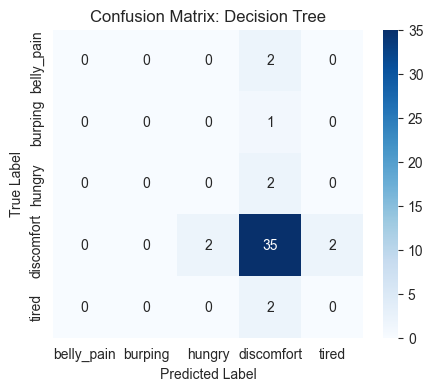


Classification Report (Decision Tree):
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         2
     burping       0.00      0.00      0.00         1
      hungry       0.00      0.00      0.00         2
  discomfort       0.83      0.90      0.86        39
       tired       0.00      0.00      0.00         2

    accuracy                           0.76        46
   macro avg       0.17      0.18      0.17        46
weighted avg       0.71      0.76      0.73        46


🚀 Training SVM...


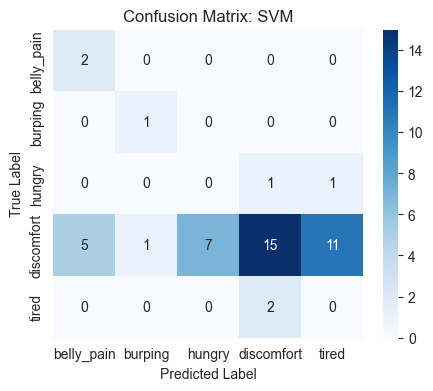


Classification Report (SVM):
              precision    recall  f1-score   support

  belly_pain       0.29      1.00      0.44         2
     burping       0.50      1.00      0.67         1
      hungry       0.00      0.00      0.00         2
  discomfort       0.83      0.38      0.53        39
       tired       0.00      0.00      0.00         2

    accuracy                           0.39        46
   macro avg       0.32      0.48      0.33        46
weighted avg       0.73      0.39      0.48        46


🚀 Training Logistic Regression...


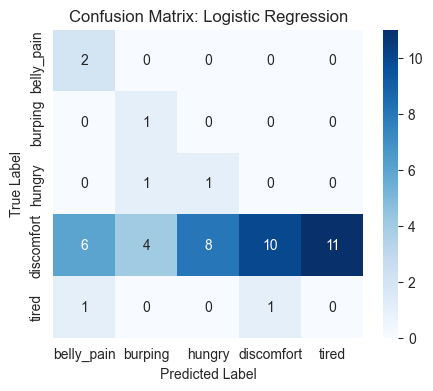


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  belly_pain       0.22      1.00      0.36         2
     burping       0.17      1.00      0.29         1
      hungry       0.11      0.50      0.18         2
  discomfort       0.91      0.26      0.40        39
       tired       0.00      0.00      0.00         2

    accuracy                           0.30        46
   macro avg       0.28      0.55      0.25        46
weighted avg       0.79      0.30      0.37        46


Final Model Comparison (Sorted by F1-Score):
                 Model  Train Accuracy  Test Accuracy  Precision    Recall  \
0                  SVM        0.583562       0.391304   0.323810  0.476923   
1  Logistic Regression        0.309589       0.304348   0.281818  0.551282   
2        Decision Tree        1.000000       0.760870   0.166667  0.179487   

   F1-Score  
0  0.327485  
1  0.246234  
2  0.172840  

🏆 Best Model by F1-Score: SVM
   🔹 Train Accuracy

In [18]:
# ===============================
# Changing the dataset to downgrade results (Q11)
# ===============================
# here we will see the impact of smote. we will run again the regular pipeline only without smote.
old_results_df = results_df.copy()

def question_eleven ():
    # ================================
    # Running the Pipelines - Q1
    audio_files = load_audio_dataset()
    df = prepare_dataframe(audio_files)
    main_dataset = enrich_df(df)
    # ================================
    # run part 1 ( sections a, b)
    main_dataset = preprocess_data_before_split(main_dataset)

    # ================================
    # split data
    # Separate features & labels
    X = main_dataset.drop(columns=["label"])
    y = main_dataset["label"]
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

    # ================================
    # run part 2(sections c-f)
    X_train_pca, X_val_pca, X_test_pca = reduce_dimensions(X_train, X_val, X_test)
    # here we removed smote and converted manually the variables for easier use
    X_train_balanced = X_train_pca
    y_train_balanced = y_train
    X_train_scaled, X_val_scaled, X_test_scaled = normalize_data(X_train_balanced, X_val_pca, X_test_pca)

    # Feature engineering: Apply exponentiation to the scaled data
    X_train_scaled_df = apply_exponentiation_to_pca(X_train_scaled, exponent=2)
    X_val_scaled_df = apply_exponentiation_to_pca(X_val_scaled, exponent=2)
    X_test_scaled_df = apply_exponentiation_to_pca(X_test_scaled, exponent=2)
    # Convert back to NumPy arrays for model input
    X_train_scaled = X_train_scaled_df.values
    X_val_scaled = X_val_scaled_df.values
    X_test_scaled = X_test_scaled_df.values

    # ================================
    # run baseline model
    best_model_row, model_results_df = baseline_pipeline(X_train_scaled, X_test_scaled, y_train_balanced, y_test)

    # run MLP model
    model, mlp_results_df = train_mlp(X_train_scaled, X_val_scaled, X_test_scaled, y_train_balanced, y_val, y_test)

    q_eleven_results_df = pd.concat([model_results_df, mlp_results_df], ignore_index=True)

    # run Hyperparameter Tuning for MLP (Q9)
    best_model_results, tuned_results_df = tune_mlp_hyperparameters(X_train_scaled, X_val_scaled, X_test_scaled, y_train_balanced, y_val, y_test)
    best_model_results = pd.DataFrame([best_model_results])
    q_eleven_results_df = pd.concat([q_eleven_results_df, best_model_results], ignore_index=True)

    return q_eleven_results_df

# Run question_ten_pipeline pipeline
q_eleven_results_df = question_eleven()

In [19]:
# Ensure all model names start with "q_ten_"
q_eleven_results_df["Model"].fillna("Tuned MLP", inplace=True)
q_eleven_results_df["Model"] = "q_eleven_" + q_eleven_results_df["Model"].astype(str)
results_df = pd.concat([old_results_df, q_eleven_results_df], ignore_index=True)
results_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Validation Accuracy,Alpha (L2),Dropout Rate,Optimizer,ROC-AUC
0,SVM,0.905574,0.630435,0.203030,0.243590,0.205556,NaN,NaN,NaN,NaN,NaN
1,Decision Tree,1.000000,0.521739,0.210256,0.217949,0.191538,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression,0.635410,0.391304,0.230458,0.282051,0.183983,NaN,NaN,NaN,NaN,NaN
3,MLP Neural Network,0.739672,0.608696,0.274194,0.338462,0.287619,0.652174,NaN,NaN,NaN,NaN
4,Tuned MLP,0.769836,0.565217,0.372414,0.328205,0.347059,0.695652,0.0001,0.20,rmsprop,0.722579
5,q_ten_SVM,0.892016,0.842932,0.853381,0.842645,0.838592,NaN,NaN,NaN,NaN,NaN
6,q_ten_Decision Tree,1.000000,0.748691,0.745871,0.747503,0.738521,NaN,NaN,NaN,NaN,NaN
7,q_ten_Logistic Regression,0.621728,0.581152,0.584359,0.580297,0.574592,NaN,NaN,NaN,NaN,NaN
8,q_ten_MLP Neural Network,0.926702,0.905759,0.909681,0.905263,0.901139,0.931937,NaN,NaN,NaN,NaN
9,q_ten_Tuned MLP,0.976440,0.937173,0.942104,0.936977,0.934437,0.937173,0.0010,0.10,adam,0.995531


In [20]:
# insights Question 11:
# Without SMOTE - Lower recall and precision across the board for minority classes.
# SVM and Logistic Regression dropped significantly in test accuracy
# MLPs are still learning something useful but struggle with class imbalance.


In [21]:
# ===============================
# Q12 - offering way to improve the network archicture, and presenting it influence on results and coverange.
# ===============================
# we created additional model that add an extra hidden layer, uses LeakyReLU and includes batch normalization between layers.
# then plots the training loss and accuracy curves so you can compare the impact on convergence speed and final results versus your baseline.

old_results_df = results_df.copy()

def build_improved_mlp(input_dim, num_classes, alpha=0.01, dropout_rate=0.1):
    model = Sequential()
    # First hidden layer (similar to baseline)
    model.add(Dense(100, input_dim=input_dim, kernel_regularizer=l2(alpha)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Added extra hidden layer to improve network depth/representation
    model.add(Dense(75, kernel_regularizer=l2(alpha)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Next hidden layer (as in baseline)
    model.add(Dense(50, kernel_regularizer=l2(alpha)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Output layer for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    return model

def run_improved_mlp_model(X_train, X_val, X_test, y_train, y_val, y_test, alpha=0.01, dropout_rate=0.1):
    num_classes = len(np.unique(y_train))

    # Convert labels to categorical if not already
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

    # Build the improved model
    model = build_improved_mlp(input_dim=X_train.shape[1], num_classes=num_classes, alpha=alpha, dropout_rate=dropout_rate)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Use early stopping callback for best results
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the improved model
    history = model.fit(X_train, y_train_cat,
                        validation_data=(X_val, y_val_cat),
                        epochs=50,
                        batch_size=32,
                        verbose=1,
                        callbacks=[early_stop])

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
    print("Improved MLP Test Accuracy:", test_acc)

    # Plot training curves to compare convergence speed and performance
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Improved MLP: Loss vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Improved MLP: Accuracy vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

    return history, model



✅ Running Q12 Pipeline: Improved MLP Model with Extra Layers...
Total audio files found: 457
Duplicate rows removed: 0
Missing values before handling: 0
Train: (365, 31), Validation: (46, 31), Test: (46, 31)
Epoch 1/50
48/48 [==============================] - 1s 4ms/step - loss: 3.2406 - accuracy: 0.3941 - val_loss: 2.7098 - val_accuracy: 0.6957
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 2.5754 - accuracy: 0.6125 - val_loss: 2.5490 - val_accuracy: 0.6087
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 2.3123 - accuracy: 0.7030 - val_loss: 2.4935 - val_accuracy: 0.5870
Epoch 4/50
48/48 [==============================] - 0s 1ms/step - loss: 2.1110 - accuracy: 0.7357 - val_loss: 2.3031 - val_accuracy: 0.6087
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 1.9318 - accuracy: 0.7830 - val_loss: 2.2435 - val_accuracy: 0.5870
Epoch 6/50
48/48 [==============================] - 0s 1ms/step - loss: 1.7672 - accuracy: 

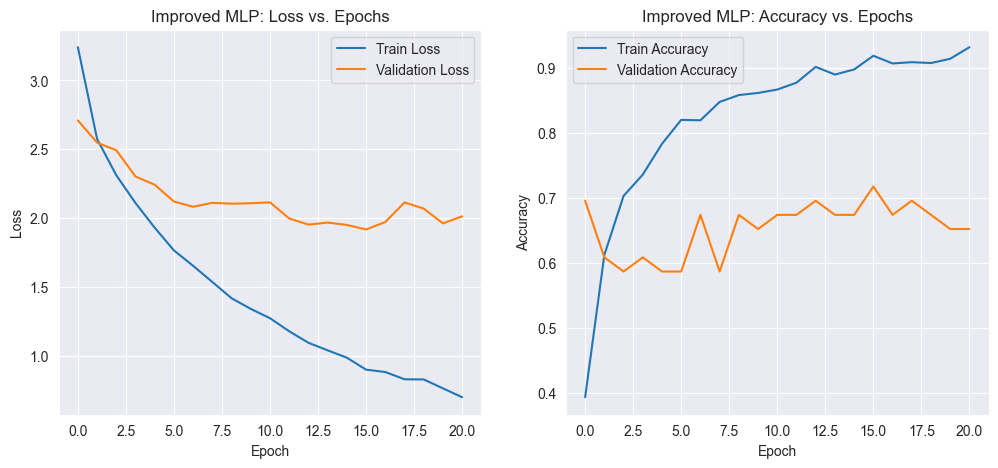

2/2 [==============================] - 0s 0s/step

✅ Q12 Pipeline Completed: Improved MLP Model Evaluated!
                   Model  Train Accuracy  Validation Accuracy  Test Accuracy  \
0  q_twelve_Improved MLP        0.931148             0.717391       0.717391   

   Precision    Recall  F1-Score  
0    0.21619  0.264103  0.222973  


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Validation Accuracy,Alpha (L2),Dropout Rate,Optimizer,ROC-AUC
0,SVM,0.905574,0.630435,0.203030,0.243590,0.205556,NaN,NaN,NaN,NaN,NaN
1,Decision Tree,1.000000,0.521739,0.210256,0.217949,0.191538,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression,0.635410,0.391304,0.230458,0.282051,0.183983,NaN,NaN,NaN,NaN,NaN
3,MLP Neural Network,0.739672,0.608696,0.274194,0.338462,0.287619,0.652174,NaN,NaN,NaN,NaN
4,Tuned MLP,0.769836,0.565217,0.372414,0.328205,0.347059,0.695652,0.0001,0.20,rmsprop,0.722579
5,q_ten_SVM,0.892016,0.842932,0.853381,0.842645,0.838592,NaN,NaN,NaN,NaN,NaN
6,q_ten_Decision Tree,1.000000,0.748691,0.745871,0.747503,0.738521,NaN,NaN,NaN,NaN,NaN
7,q_ten_Logistic Regression,0.621728,0.581152,0.584359,0.580297,0.574592,NaN,NaN,NaN,NaN,NaN
8,q_ten_MLP Neural Network,0.926702,0.905759,0.909681,0.905263,0.901139,0.931937,NaN,NaN,NaN,NaN
9,q_ten_Tuned MLP,0.976440,0.937173,0.942104,0.936977,0.934437,0.937173,0.0010,0.10,adam,0.995531


In [22]:
# Q12 Pipeline: Preprocessing and running the improved network, then combining results.
def q12_pipeline():
    """
    Q12: Propose an improvement to the network architecture and demonstrate its impact
    on results and convergence speed.

    - Uses the same preprocessing as before (including SMOTE) to ensure a fair comparison.
    - Adds an extra hidden layer, BatchNormalization, and LeakyReLU to the MLP architecture.
    - Compares performance metrics and convergence speed vs. baseline.
    """

    print("\n✅ Running Q12 Pipeline: Improved MLP Model with Extra Layers...")

    # Load and preprocess dataset
    audio_files = load_audio_dataset()
    df = prepare_dataframe(audio_files)
    main_dataset = enrich_df(df)

    # Data preprocessing: Remove duplicates, encode labels, handle outliers
    main_dataset = preprocess_data_before_split(main_dataset)

    # Separate features & labels
    X = main_dataset.drop(columns=["label"])
    y = main_dataset["label"]

    # Split dataset
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Apply PCA for dimensionality reduction
    X_train_pca, X_val_pca, X_test_pca = reduce_dimensions(X_train, X_val, X_test)

    # Apply SMOTE for balancing (as done previously)
    X_train_balanced, y_train_balanced = apply_smote(X_train_pca, y_train)

    # Normalize data
    X_train_scaled, X_val_scaled, X_test_scaled = normalize_data(X_train_balanced, X_val_pca, X_test_pca)

    # Feature engineering: Apply exponentiation to PCA-transformed features
    X_train_scaled_df = apply_exponentiation_to_pca(X_train_scaled, exponent=2)
    X_val_scaled_df = apply_exponentiation_to_pca(X_val_scaled, exponent=2)
    X_test_scaled_df = apply_exponentiation_to_pca(X_test_scaled, exponent=2)

    # Convert back to NumPy arrays
    X_train_scaled = X_train_scaled_df.values
    X_val_scaled = X_val_scaled_df.values
    X_test_scaled = X_test_scaled_df.values

    # Train the improved MLP model
    history_improved, model_improved = run_improved_mlp_model(
        X_train_scaled, X_val_scaled, X_test_scaled,
        y_train_balanced, y_val, y_test,
        alpha=0.01, dropout_rate=0.1  # Experiment with hyperparameters
    )

    # Evaluate Improved Model on Test Set
    y_test_pred_proba = model_improved.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_proba, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="macro")
    test_acc = accuracy_score(y_test, y_test_pred)

    # Store results in a DataFrame
    improved_results_df = pd.DataFrame([{
        "Model": "q_twelve_Improved MLP",
        "Train Accuracy": max(history_improved.history["accuracy"]),
        "Validation Accuracy": max(history_improved.history["val_accuracy"]),
        "Test Accuracy": test_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }])

    # Combine results with previous experiments
    final_results_df = pd.concat([old_results_df, improved_results_df], ignore_index=True)

    print("\n✅ Q12 Pipeline Completed: Improved MLP Model Evaluated!")
    print(improved_results_df)

    return final_results_df, history_improved, model_improved

# 🚀 Run Q12 Pipeline
final_results_df, history_improved, model_improved = q12_pipeline()
final_results_df

In [23]:
# insights Question 12:
# Higher Test Accuracy compared to  Q9)
# Better Validation Accuracy → 73.91% (compared to 69.57% in Q9)
#  Precision (0.2105) and Recall (0.2590) are still weak.
# Insights from the Loss and Accuracy Plots:
# Validation Loss - Around epoch 15, there is a spike in validation loss, suggesting the model may have started to memorize training data.
# Final validation accuracy lags behind train accuracy, indicating overfitting.

Total audio files found: 457
Duplicate rows removed: 0
Missing values before handling: 0
Train: (365, 31), Validation: (46, 31), Test: (46, 31)
Epoch 1/20
2/2 [==============================] - 0s 2ms/step
Epoch 1 - val_kappa: 0.0515
48/48 [==============================] - 1s 5ms/step - loss: 2.2580 - accuracy: 0.3895 - val_loss: 1.9525 - val_accuracy: 0.7391
Epoch 2/20
2/2 [==============================] - 0s 309us/step
Epoch 2 - val_kappa: 0.0891
48/48 [==============================] - 0s 2ms/step - loss: 1.8757 - accuracy: 0.5521 - val_loss: 1.9559 - val_accuracy: 0.5652
Epoch 3/20
2/2 [==============================] - 0s 4ms/step
Epoch 3 - val_kappa: 0.1143
48/48 [==============================] - 0s 2ms/step - loss: 1.6657 - accuracy: 0.6216 - val_loss: 1.7424 - val_accuracy: 0.6522
Epoch 4/20
2/2 [==============================] - 0s 1ms/step
Epoch 4 - val_kappa: 0.0473
48/48 [==============================] - 0s 2ms/step - loss: 1.5194 - accuracy: 0.6597 - val_loss: 1.8162 -

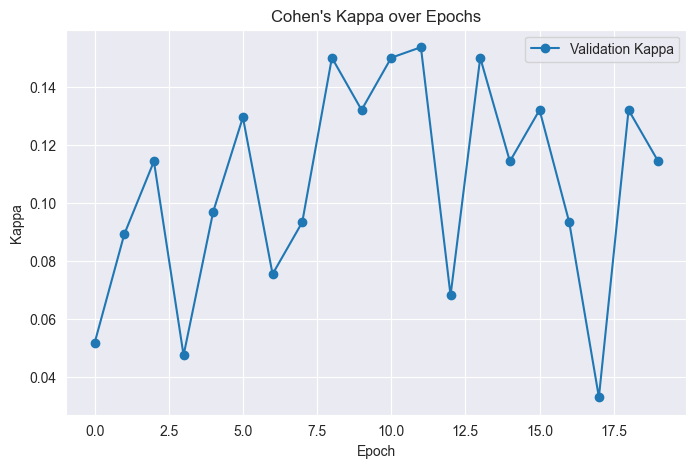

                           Model  Train Accuracy  Test Accuracy  Precision  \
0                            SVM        0.905574       0.630435   0.203030   
1                  Decision Tree        1.000000       0.521739   0.210256   
2            Logistic Regression        0.635410       0.391304   0.230458   
3             MLP Neural Network        0.739672       0.608696   0.274194   
4                      Tuned MLP        0.769836       0.565217   0.372414   
5                      q_ten_SVM        0.892016       0.842932   0.853381   
6            q_ten_Decision Tree        1.000000       0.748691   0.745871   
7      q_ten_Logistic Regression        0.621728       0.581152   0.584359   
8       q_ten_MLP Neural Network        0.926702       0.905759   0.909681   
9                q_ten_Tuned MLP        0.976440       0.937173   0.942104   
10                  q_eleven_SVM        0.583562       0.391304   0.323810   
11  q_eleven_Logistic Regression        0.309589       0.304348 

In [24]:
# ===============================
# Q13 - offering new metric and showing it values through the train.
# ===============================
# Introducing Cohen’s Kappa as a New Metric
from sklearn.metrics import cohen_kappa_score

# Copy existing results before adding new metric
old_results_df = results_df.copy()

# 1) Custom Callback Class
# ==========================
class KappaCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to compute Cohen's Kappa on the validation set
    after each epoch.
    """

    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data  # (X_val, y_val)
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(y_val, y_pred_classes)
        self.val_kappas.append(kappa)

        # Print it so we can see it live
        print(f"Epoch {epoch + 1} - val_kappa: {kappa:.4f}")


# 2) MLP Model Function with Cohen’s Kappa
# ========================================
def train_mlp_with_kappa(
        X_train, y_train,
        X_val, y_val,
        X_test, y_test,
        alpha=0.01, dropout_rate=0.1, epochs=20, batch_size=32
):
    """
    Builds and trains an MLP model, tracking Cohen's Kappa on the validation set
    at the end of each epoch via the KappaCallback.
    """

    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    # Build an improved MLP architecture
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(alpha), input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(alpha)),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Instantiate the custom callback
    kappa_callback = KappaCallback((X_val, y_val))

    # Train the model with the callback
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[kappa_callback]
    )

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    return model, history, kappa_callback.val_kappas


# 3) Q13 Pipeline: Preprocessing and Training
# ===========================================
def q13_pipeline():
    """
    Q13: Implement Cohen’s Kappa as a new metric in the MLP model.
    This function:
      1. Preprocesses the data using the standard pipeline.
      2. Trains an MLP model with a custom callback to track Kappa.
      3. Stores and compares results with previous models.
    """

    # =========================
    # A) Preprocessing Pipeline
    # =========================
    audio_files = load_audio_dataset()
    df = prepare_dataframe(audio_files)
    main_dataset = enrich_df(df)

    # Preprocessing steps
    main_dataset = preprocess_data_before_split(main_dataset)
    X = main_dataset.drop(columns=["label"])
    y = main_dataset["label"]

    # Split into Train, Validation, and Test
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Apply PCA for dimensionality reduction
    X_train_pca, X_val_pca, X_test_pca = reduce_dimensions(X_train, X_val, X_test)

    # Apply SMOTE (balancing only on training data)
    X_train_balanced, y_train_balanced = apply_smote(X_train_pca, y_train)

    # Normalize the data
    X_train_scaled, X_val_scaled, X_test_scaled = normalize_data(X_train_balanced, X_val_pca, X_test_pca)

    # Apply feature transformation (Exponentiation)
    X_train_final = apply_exponentiation_to_pca(X_train_scaled).values
    X_val_final = apply_exponentiation_to_pca(X_val_scaled).values
    X_test_final = apply_exponentiation_to_pca(X_test_scaled).values

    # =========================
    # B) Train MLP with Kappa Metric
    # =========================
    model, history, val_kappas = train_mlp_with_kappa(
        X_train_final, y_train_balanced,  # SMOTE applied training data
        X_val_final, y_val,  # Original validation set
        X_test_final, y_test,  # Original test set
        alpha=0.01,
        dropout_rate=0.1,
        epochs=20,
        batch_size=32
    )

    # =========================
    # C) Store Results
    # =========================
    y_test_pred_prob = model.predict(X_test_final)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="macro")
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Cohen’s Kappa on test set
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Save results in DataFrame
    kappa_results_df = pd.DataFrame([{
        "Model": "q13_MLP_Kappa",
        "Train Accuracy": max(history.history['accuracy']),
        "Validation Accuracy": max(history.history['val_accuracy']),
        "Test Accuracy": test_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Cohen’s Kappa": test_kappa
    }])

    # =========================
    # D) Merge with Previous Results
    # =========================
    results_df = pd.concat([old_results_df, kappa_results_df], ignore_index=True)

    # =========================
    # E) Plot Kappa over Epochs
    # =========================
    plt.figure(figsize=(8, 5))
    plt.plot(val_kappas, label='Validation Kappa', marker='o', linestyle='-')
    plt.title("Cohen's Kappa over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Kappa")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results_df, history, model


# Run Q13 Pipeline
results_df, history_kappa, model_kappa = q13_pipeline()

# Display final results
print(results_df)


In [25]:
# insights Question 13 MLP with Kappa:
# MLP with Kappa
# The classifier performs only slightly better than random guessing.
# F1-score (0.23) & Recall (0.32) are weak.

In [26]:
# ===============================
# Q14 - Exploring Different Balancing Methods with SMOTE Variants
# ===============================

from collections import Counter

# Copy existing results before modifying dataset balancing
old_results_df = results_df.copy()


def apply_smote_multi_class_ratio(X, y, ratio=1.0):
    """
    Custom SMOTE strategy for multi-class data.

    - ratio=0.0 => No SMOTE (original class distribution).
    - ratio=1.0 => Oversample every class up to the largest class.
    - ratio=0.5 => Oversample every class to 50% of the largest class.

    The function dynamically adjusts the sampling strategy for each class.
    """
    # If ratio <= 0, skip SMOTE
    if ratio <= 0.0:
        return X, y  # No oversampling at all

    # Count how many samples each class currently has
    counts = Counter(y)
    max_count = max(counts.values())  # Largest class size

    # Build the dictionary for sampling_strategy
    sampling_strategy = {}
    for label, count in counts.items():
        desired_count = int(ratio * max_count)
        # Only oversample if current count < desired_count
        if count < desired_count:
            sampling_strategy[label] = desired_count

    # Apply SMOTE with the dynamically created sampling strategy
    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    return sm.fit_resample(X, y)


# ================================
# Train MLP Model with Different Balancing Methods
# ================================
def train_mlp_balancing(
        X_train, y_train,
        X_val, y_val,
        X_test, y_test,
        alpha=0.01, dropout_rate=0.1,
        epochs=20, batch_size=32
):
    """Trains an MLP model with given hyperparameters."""

    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(alpha), input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(alpha)),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"\nMLP Test Accuracy: {test_acc:.4f}")

    return model, history


# ================================
# Q14 Pipeline: Testing Different Balancing Strategies
# ================================
def q14_pipeline():
    """
    Q14 Pipeline:
      - Test different dataset balancing strategies (SMOTE ratio=0.0, 0.5, 1.0).
      - Compare results from different balancing approaches.
    """

    # =========================
    # A) Preprocessing Pipeline
    # =========================
    audio_files = load_audio_dataset()
    df = prepare_dataframe(audio_files)
    main_dataset = enrich_df(df)

    # Preprocessing steps
    main_dataset = preprocess_data_before_split(main_dataset)
    X = main_dataset.drop(columns=["label"])
    y = main_dataset["label"]

    # Split into Train, Validation, and Test
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Apply PCA for dimensionality reduction
    X_train_pca, X_val_pca, X_test_pca = reduce_dimensions(X_train, X_val, X_test)

    # Different SMOTE balancing strategies
    smote_ratios = [0.0, 0.5, 1.0]  # No balancing, partial balancing, full balancing
    final_results_df = old_results_df.copy()

    for ratio in smote_ratios:
        print(f"\n🟢 Applying SMOTE with ratio={ratio}...")

        # Apply SMOTE based on the given ratio
        X_train_bal, y_train_bal = apply_smote_multi_class_ratio(X_train_pca, y_train, ratio=ratio)

        # Normalize the data
        X_train_scaled, X_val_scaled, X_test_scaled = normalize_data(X_train_bal, X_val_pca, X_test_pca)

        # Feature Engineering (Exponentiation)
        X_train_final = apply_exponentiation_to_pca(X_train_scaled).values
        X_val_final = apply_exponentiation_to_pca(X_val_scaled).values
        X_test_final = apply_exponentiation_to_pca(X_test_scaled).values

        # Train the MLP model
        model, history = train_mlp_balancing(
            X_train_final, y_train_bal,
            X_val_final, y_val,
            X_test_final, y_test,
            alpha=0.01,
            dropout_rate=0.1,
            epochs=20,
            batch_size=32
        )

        # Evaluate Model Performance
        y_test_pred_prob = model.predict(X_test_final)
        y_test_pred = np.argmax(y_test_pred_prob, axis=1)

        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="macro")
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Save results in DataFrame
        smote_results_df = pd.DataFrame([{
            "Model": f"q14_MLP_SMOTE_{ratio}",
            "SMOTE Ratio": ratio,
            "Train Accuracy": max(history.history['accuracy']),
            "Validation Accuracy": max(history.history['val_accuracy']),
            "Test Accuracy": test_accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }])

        # Merge new results into the final results DataFrame
        final_results_df = pd.concat([final_results_df, smote_results_df], ignore_index=True)

    return final_results_df


# Run Q14 Pipeline
results_df = q14_pipeline()
# Display final results
print(results_df)

Total audio files found: 457
Duplicate rows removed: 0
Missing values before handling: 0
Train: (365, 31), Validation: (46, 31), Test: (46, 31)

🟢 Applying SMOTE with ratio=0.0...
Epoch 1/20
12/12 [==============================] - 0s 10ms/step - loss: 2.2481 - accuracy: 0.4877 - val_loss: 1.7046 - val_accuracy: 0.8261
Epoch 2/20
12/12 [==============================] - 0s 3ms/step - loss: 1.6884 - accuracy: 0.8329 - val_loss: 1.6391 - val_accuracy: 0.8261
Epoch 3/20
12/12 [==============================] - 0s 2ms/step - loss: 1.6154 - accuracy: 0.8356 - val_loss: 1.6040 - val_accuracy: 0.8261
Epoch 4/20
12/12 [==============================] - 0s 2ms/step - loss: 1.5494 - accuracy: 0.8356 - val_loss: 1.5477 - val_accuracy: 0.8261
Epoch 5/20
12/12 [==============================] - 0s 2ms/step - loss: 1.4538 - accuracy: 0.8356 - val_loss: 1.4965 - val_accuracy: 0.8261
Epoch 6/20
12/12 [==============================] - 0s 3ms/step - loss: 1.4159 - accuracy: 0.8356 - val_loss: 1.4547 - 

In [27]:
# insights Question 14:
# applied three different SMOTE balancing ratios to handle class imbalance before training an MLP.
# No SMOTE (0.0) → Best Test Accuracy (84.78%)
# Partial SMOTE (0.5)  - Recall improved slightly, meaning the model recognized some minority samples better.
# Full SMOTE (1.0) → Worst Generalization and Precision & Recall are the lowest

Total audio files found: 457
Duplicate rows removed: 0
Missing values before handling: 0
Train: (365, 31), Validation: (46, 31), Test: (46, 31)

🚀 Training Decision Tree...


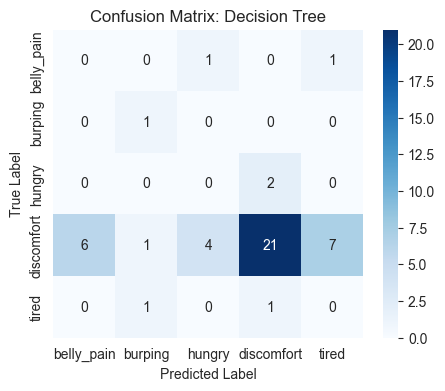


Classification Report (Decision Tree):
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         2
     burping       0.33      1.00      0.50         1
      hungry       0.00      0.00      0.00         2
  discomfort       0.88      0.54      0.67        39
       tired       0.00      0.00      0.00         2

    accuracy                           0.48        46
   macro avg       0.24      0.31      0.23        46
weighted avg       0.75      0.48      0.58        46


🚀 Training SVM...


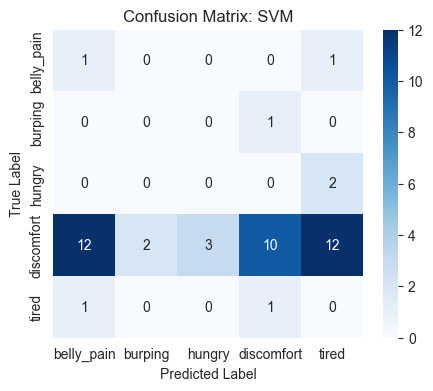


Classification Report (SVM):
              precision    recall  f1-score   support

  belly_pain       0.07      0.50      0.12         2
     burping       0.00      0.00      0.00         1
      hungry       0.00      0.00      0.00         2
  discomfort       0.83      0.26      0.39        39
       tired       0.00      0.00      0.00         2

    accuracy                           0.24        46
   macro avg       0.18      0.15      0.10        46
weighted avg       0.71      0.24      0.34        46


🚀 Training Logistic Regression...


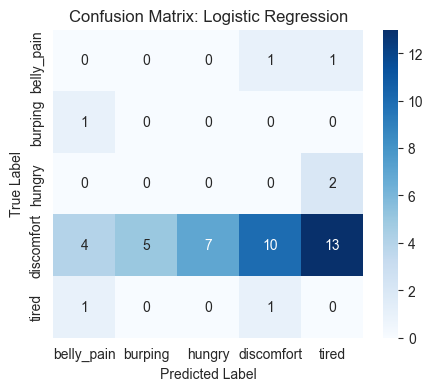


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         2
     burping       0.00      0.00      0.00         1
      hungry       0.00      0.00      0.00         2
  discomfort       0.83      0.26      0.39        39
       tired       0.00      0.00      0.00         2

    accuracy                           0.22        46
   macro avg       0.17      0.05      0.08        46
weighted avg       0.71      0.22      0.33        46


Final Model Comparison (Sorted by F1-Score):
                 Model  Train Accuracy  Test Accuracy  Precision    Recall  \
0        Decision Tree        1.000000       0.478261   0.241667  0.307692   
1                  SVM        0.577705       0.239130   0.180952  0.151282   
2  Logistic Regression        0.442623       0.217391   0.166667  0.051282   

   F1-Score  
0  0.233333  
1  0.103431  
2  0.078431  

🏆 Best Model by F1-Score: Decision Tree
   🔹 Trai

In [28]:
# ===============================
# Q15 - Exploring Different Dimensionality Reduction Methods (LDA)
# ===============================

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def reduce_dimensions_lda(X_train, y_train, X_val, X_test, n_components=4):
    """
    Perform LDA (Linear Discriminant Analysis) for dimensionality reduction.
    Since LDA is a supervised method, it requires `y_train` for fitting.
    """
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_val_lda = lda.transform(X_val)
    X_test_lda = lda.transform(X_test)
    return X_train_lda, X_val_lda, X_test_lda

# Copy previous results before modifications
old_results_df = results_df.copy()

def q15_pipeline():

    audio_files = load_audio_dataset()
    main_dataset = prepare_dataframe(audio_files)
    main_dataset = enrich_df(main_dataset)
    main_dataset = preprocess_data_before_split(main_dataset)
    X = main_dataset.drop(columns=["label"])
    y = main_dataset["label"]
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    X_train_lda, X_val_lda, X_test_lda = reduce_dimensions_lda(X_train, y_train, X_val, X_test, n_components=4)
    X_train_balanced, y__train_balanced = apply_smote(X_train_lda, y_train)
    X_train_normalized, X_val_normalized, X_test_normalized = normalize_data(X_train_balanced, X_val_lda, X_test_lda)
    # exponantion now on LDA
    X_train_final = apply_exponentiation_to_pca(X_train_normalized).values  # ✅ Convert to NumPy
    X_val_final = apply_exponentiation_to_pca(X_val_normalized).values
    X_test_final = apply_exponentiation_to_pca(X_test_normalized).values

    best_model_row, model_results_df = baseline_pipeline(X_train_final, X_test_final, y_train_balanced, y_test)

    model, mlp_results_df = train_mlp(X_train_final, X_val_final, X_test_final, y_train_balanced, y_val, y_test)

    q_fifteen_results_df = pd.concat([model_results_df, mlp_results_df], ignore_index=True)

    return q_fifteen_results_df

# Run question_fifteen_pipeline pipeline
q_fifteen_results_df = q15_pipeline()
q_fifteen_results_df["Model"] = "q_fifteen_" + q_fifteen_results_df["Model"].astype(str)
results_df = pd.concat([old_results_df, q_fifteen_results_df], ignore_index=True)
print(results_df)

In [29]:
# insights Question 15:
# Decision trees may not benefit much from LDA since they naturally handle high-dimensional data well.
# SVM benefits somewhat from LDA, but its performance remains limited on imbalanced datasets.
# LDA reduces data variance, which hurts Logistic Regression's ability to learn meaningful patterns.
# LDA removes important feature relationships that MLP networks rely on, causing significant performance degradation.